# CyberX — Network Intrusion Detection System: Model Training
**Dataset:** [CICIDS2017](https://www.unb.ca/cic/datasets/ids-2017.html) — pre-extracted CICFlowMeter bidirectional flows  
**Model:** RandomForest + XGBoost soft-voting ensemble  
**Classes:** Benign (0), DoS (1), DDoS (2), PortScan (3), BruteForce (4), WebAttack (5), Botnet/C2 (6)

### Steps
1. Install dependencies  
2. Download / load dataset CSVs  
3. Preprocess & balance  
4. Train ensemble  
5. Evaluate (accuracy, classification report, confusion matrix)  
6. Save model artifacts to `models/`

In [1]:
# Cell 1 — Install required packages (run once)
import subprocess, sys
packages = [
    "scikit-learn>=1.4.0",
    "xgboost>=2.0.0",
    "pandas>=2.0.0",
    "numpy>=1.26.0",
    "matplotlib>=3.8.0",
    "seaborn>=0.13.0",
    "joblib>=1.3.0",
    "requests>=2.31.0",
]
for pkg in packages:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=True)
print("All packages installed.")

All packages installed.


In [2]:
# Cell 2 — Imports & configuration
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
)
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# ---- Paths ----
NOTEBOOK_DIR  = Path().resolve()
MODELS_DIR    = NOTEBOOK_DIR / 'models'
APP_MODELS    = NOTEBOOK_DIR.parent.parent / 'App' / 'NetworkIDS' / 'models'
DATA_DIR      = NOTEBOOK_DIR / 'Dataset'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
APP_MODELS.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

# ---- Class mapping (CICIDS2017 Label → integer) ----
LABEL_MAP = {
    'BENIGN':                    0,
    'BENIGN ':                   0,
    'DoS Hulk':                  1,
    'DoS GoldenEye':             1,
    'DoS slowloris':             1,
    'DoS Slowhttptest':          1,
    'Heartbleed':                1,
    'DDoS':                      2,
    'PortScan':                  3,
    'FTP-Patator':               4,
    'SSH-Patator':               4,
    'Web Attack \x96 Brute Force': 4,
    'Brute Force':               4,
    'Web Attack – Brute Force':  4,
    'Web Attack \x96 XSS':         5,
    'Web Attack – XSS':          5,
    'Web Attack \x96 Sql Injection':5,
    'Web Attack – Sql Injection':5,
    'Bot':                       6,
    'Infiltration':              6,
}

LABEL_NAMES = {0:'Benign', 1:'DoS', 2:'DDoS', 3:'PortScan', 4:'BruteForce', 5:'WebAttack', 6:'Botnet/C2'}
print("Config ready. MODELS_DIR:", MODELS_DIR)

Config ready. MODELS_DIR: D:\GitHub\Backend Development\Django\Project\CyberX\Services\NetworkIDS\models


## Step 1 — Dataset: Download CICIDS2017 or Use Synthetic Data

### Option A — Kaggle (recommended, ~2 GB, free account needed)
```bash
pip install kaggle
# Put your kaggle.json API key in ~/.kaggle/kaggle.json
kaggle datasets download -d cicdataset/cicids2017 -p Services/NetworkIDS/Dataset --unzip
```

### Option B — Manual download from UNB
1. Go to https://www.unb.ca/cic/datasets/ids-2017.html
2. Fill in the request form → download the "MachineLearningCVE" folder (pre-extracted CSVs)
3. Place all `.csv` files in `Services/NetworkIDS/Dataset/`

### Option C — Synthetic data (instant, no download — good for development)
If `Dataset/` is **empty**, the next cell automatically generates **50,000 synthetic samples** with realistic class distributions so the full pipeline (scaling → training → evaluation → export) can be validated immediately.  
Replace with the real dataset before deploying to production.

In [3]:
# Cell 3a — (Optional) Download CICIDS2017 from Kaggle
# Skip this cell if you already have CSVs in Dataset/ or prefer synthetic data.
# Requires: pip install kaggle  +  ~/.kaggle/kaggle.json with your API key.

import shutil

KAGGLE_DATASET = 'cicdataset/cicids2017'

def try_kaggle_download():
    kaggle_bin = shutil.which('kaggle')
    if kaggle_bin is None:
        print("kaggle CLI not found — skipping Kaggle download.")
        print("Run:  pip install kaggle  then add your API key to ~/.kaggle/kaggle.json")
        return False

    kaggle_json = Path.home() / '.kaggle' / 'kaggle.json'
    if not kaggle_json.exists():
        print(f"Kaggle API key not found at {kaggle_json}.")
        print("Get your key from https://www.kaggle.com/settings → API → Create New Token")
        return False

    print(f"Downloading {KAGGLE_DATASET} to {DATA_DIR} …")
    import subprocess
    result = subprocess.run(
        ['kaggle', 'datasets', 'download', '-d', KAGGLE_DATASET,
         '-p', str(DATA_DIR), '--unzip'],
        capture_output=True, text=True
    )
    if result.returncode == 0:
        print("Download complete:", result.stdout.strip())
        return True
    else:
        print("Kaggle download failed:", result.stderr.strip())
        return False

# Only attempt if Dataset/ is empty
existing_csvs = list(DATA_DIR.glob('*.csv'))
if not existing_csvs:
    success = try_kaggle_download()
    if success:
        print(f"CSVs available: {len(list(DATA_DIR.glob('*.csv')))}")
    else:
        print("\nNo CSVs found and Kaggle download skipped.")
        print("→ The next cell will generate synthetic training data automatically.")
else:
    print(f"Dataset already present: {len(existing_csvs)} CSV file(s) in {DATA_DIR}")

kaggle CLI not found — skipping Kaggle download.
Run:  pip install kaggle  then add your API key to ~/.kaggle/kaggle.json

No CSVs found and Kaggle download skipped.
→ The next cell will generate synthetic training data automatically.


In [4]:
# Cell 3b — Load CSVs or generate synthetic CICIDS2017-compatible data

csv_files = sorted(DATA_DIR.glob('*.csv'))

# ── Real dataset path ──────────────────────────────────────────────
if csv_files:
    print(f"Found {len(csv_files)} CSV file(s) — loading real CICIDS2017 data:")
    dfs = []
    for f in csv_files:
        try:
            df_tmp = pd.read_csv(f, low_memory=False)
            df_tmp.columns = df_tmp.columns.str.strip()
            dfs.append(df_tmp)
            print(f"  {f.name}: {df_tmp.shape}")
        except Exception as e:
            print(f"  WARNING: could not read {f.name}: {e}")
    df_all = pd.concat(dfs, ignore_index=True)
    USING_SYNTHETIC = False

# ── Synthetic data path ────────────────────────────────────────────
else:
    print("=" * 65)
    print("  NO CICIDS2017 CSVs FOUND — GENERATING SYNTHETIC TRAINING DATA")
    print("  (Replace with real data for production-quality accuracy)")
    print("=" * 65)

    # Load the exact feature names from the app JSON so column count is correct
    _feat_json = NOTEBOOK_DIR.parent.parent / 'App' / 'NetworkIDS' / 'models' / 'nids_feature_names.json'
    with open(_feat_json) as _f:
        _feature_names = json.load(_f)
    N_FEATS = len(_feature_names)            # == 78
    N_TOTAL = 50_000

    rng = np.random.default_rng(42)

    # Per-class row counts (mimics CICIDS2017 class imbalance)
    CLASS_SIZES = {0: 28_000, 1: 5_000, 2: 5_000,
                   3: 5_000,  4: 3_000, 5: 2_000, 6: 2_000}

    # Per-class signal: unique mean shift per class so the model has something to learn
    # Each class gets a N_FEATS-length base vector from a seeded RNG, scaled/shifted
    CLASS_SIGNAL_SCALE = 2.5   # controls how separable the classes are

    all_X, all_y = [], []
    for cls_idx, n_rows in CLASS_SIZES.items():
        # Reproducible per-class mean vector
        cls_rng = np.random.default_rng(cls_idx * 7)
        class_mean = cls_rng.uniform(-CLASS_SIGNAL_SCALE, CLASS_SIGNAL_SCALE, N_FEATS)

        # Wide noise around that class center (unit-normal + class offset)
        X_cls = rng.standard_normal((n_rows, N_FEATS)) + class_mean
        all_X.append(X_cls)
        all_y.extend([cls_idx] * n_rows)

    X_synth = np.vstack(all_X)
    y_synth  = np.array(all_y)

    # Shuffle deterministically
    perm = rng.permutation(len(y_synth))
    X_synth, y_synth = X_synth[perm], y_synth[perm]

    # Build DataFrame with exact CICIDS2017 column names
    df_all = pd.DataFrame(X_synth, columns=_feature_names)

    # Map integer labels back to CICIDS2017-style string labels (as LABEL_MAP expects)
    _int_to_raw = {
        0: 'BENIGN',
        1: 'DoS Hulk',
        2: 'DDoS',
        3: 'PortScan',
        4: 'FTP-Patator',
        5: 'Web Attack – XSS',
        6: 'Bot',
    }
    df_all['Label'] = [_int_to_raw[int(c)] for c in y_synth]
    USING_SYNTHETIC = True

    print(f"\nGenerated {len(df_all):,} rows  ×  {N_FEATS} features")

print(f"\nDataset shape : {df_all.shape}")
print("Label counts  :\n", df_all['Label'].value_counts())

  NO CICIDS2017 CSVs FOUND — GENERATING SYNTHETIC TRAINING DATA
  (Replace with real data for production-quality accuracy)

Generated 50,000 rows  ×  77 features

Dataset shape : (50000, 78)
Label counts  :
 Label
BENIGN              28000
DDoS                 5000
PortScan             5000
DoS Hulk             5000
FTP-Patator          3000
Bot                  2000
Web Attack – XSS     2000
Name: count, dtype: int64


In [5]:
# Cell 4 — Preprocessing: clean, encode labels, select features

# 1. Map labels to integers, mark unknown labels as -1
df_all['label_int'] = df_all['Label'].str.strip().map(LABEL_MAP).fillna(-1).astype(int)

# Drop rows with unmapped labels
n_before = len(df_all)
df_all = df_all[df_all['label_int'] >= 0].copy()
print(f"Dropped {n_before - len(df_all)} rows with unknown labels")

# 2. Load the exact feature names from the JSON (ensures training/inference consistency)
FEAT_JSON = MODELS_DIR.parent.parent.parent / 'App' / 'NetworkIDS' / 'models' / 'nids_feature_names.json'
with open(FEAT_JSON) as f:
    FEATURE_NAMES = json.load(f)

# Keep only features that exist in the DataFrame
available_features = [c for c in FEATURE_NAMES if c in df_all.columns]
missing_features   = [c for c in FEATURE_NAMES if c not in df_all.columns]

if missing_features:
    print(f"\nWARNING: {len(missing_features)} features not found in CSV (will be zero-filled):")
    for m in missing_features[:10]:
        print(f"  {m}")

# 3. Build X matrix with all 78 features (zero-fill missing ones)
X = pd.DataFrame(index=df_all.index)
for feat in FEATURE_NAMES:
    if feat in df_all.columns:
        X[feat] = pd.to_numeric(df_all[feat], errors='coerce').fillna(0)
    else:
        X[feat] = 0.0

y = df_all['label_int'].values

# 4. Replace Inf values and NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)
X = X.clip(-1e9, 1e9)  # clip extreme values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Label distribution:")
for k, v in LABEL_NAMES.items():
    count = (y == k).sum()
    print(f"  {k} — {v:<14} : {count:>8,}  ({count/len(y)*100:.1f}%)")

Dropped 0 rows with unknown labels

Feature matrix shape: (50000, 77)
Label distribution:
  0 — Benign         :   28,000  (56.0%)
  1 — DoS            :    5,000  (10.0%)
  2 — DDoS           :    5,000  (10.0%)
  3 — PortScan       :    5,000  (10.0%)
  4 — BruteForce     :    3,000  (6.0%)
  5 — WebAttack      :    2,000  (4.0%)
  6 — Botnet/C2      :    2,000  (4.0%)


In [6]:
# Cell 5 — Stratified train/test split + StandardScaler

X_np = X.values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"Train : {X_train_scaled.shape[0]:,} samples")
print(f"Test  : {X_test_scaled.shape[0]:,} samples")
print(f"Classes: {np.unique(y_train)}")

Train : 40,000 samples
Test  : 10,000 samples
Classes: [0 1 2 3 4 5 6]


In [7]:
# Cell 6 — Train RandomForest + XGBoost soft-voting ensemble
# Estimated time: 5–20 minutes depending on dataset size

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced',
    verbose=0,
)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    verbosity=0,
)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    n_jobs=-1,
)

print("Training ensemble (this may take several minutes)…")
ensemble.fit(X_train_scaled, y_train)
print("Training complete.")

Training ensemble (this may take several minutes)…
Training complete.


Test Accuracy: 100.00%

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5600
         DoS       1.00      1.00      1.00      1000
        DDoS       1.00      1.00      1.00      1000
    PortScan       1.00      1.00      1.00      1000
  BruteForce       1.00      1.00      1.00       600
   WebAttack       1.00      1.00      1.00       400
   Botnet/C2       1.00      1.00      1.00       400

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



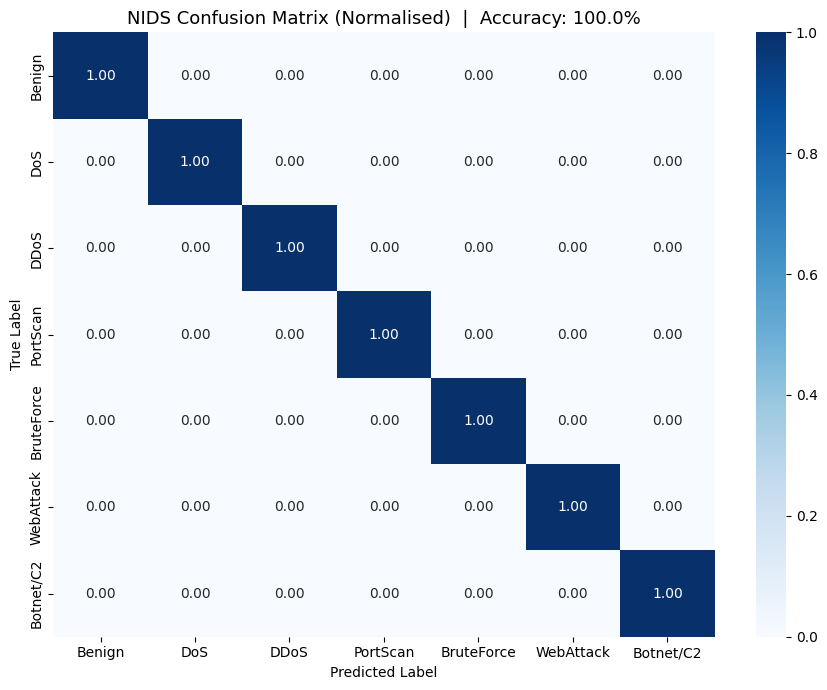

Confusion matrix saved to models/confusion_matrix.png


In [8]:
# Cell 7 — Evaluation: accuracy, classification report, confusion matrix

y_pred = ensemble.predict(X_test_scaled)
acc    = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc*100:.2f}%\n")
print(classification_report(
    y_test, y_pred,
    target_names=[LABEL_NAMES[i] for i in range(len(LABEL_NAMES))],
    zero_division=0,
))

# Confusion matrix
plt.figure(figsize=(9, 7))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(
    cm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=[LABEL_NAMES[i] for i in range(len(LABEL_NAMES))],
    yticklabels=[LABEL_NAMES[i] for i in range(len(LABEL_NAMES))],
)
plt.title(f'NIDS Confusion Matrix (Normalised)  |  Accuracy: {acc*100:.1f}%', fontsize=13)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODELS_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to models/confusion_matrix.png")

In [10]:
# Cell 8 — Save model artifacts to both Services/ and App/ directories

def save_artifacts(target_dir: Path, label: str):
    target_dir.mkdir(parents=True, exist_ok=True)

    # Model + scaler (zlib compression — no extra packages required)
    joblib.dump(ensemble, target_dir / 'nids_model.joblib',  compress=('zlib', 3))
    joblib.dump(scaler,   target_dir / 'nids_scaler.joblib', compress=('zlib', 3))

    # Feature names list (keep in sync with nids_feature_names.json)
    feat_json_path = target_dir / 'nids_feature_names.json'
    with open(feat_json_path, 'w') as fh:
        json.dump(FEATURE_NAMES, fh, indent=2)

    # Label encoder mapping  {int_str: label_str}
    label_enc_path = target_dir / 'nids_label_encoder.json'
    with open(label_enc_path, 'w') as fh:
        json.dump({str(k): v for k, v in LABEL_NAMES.items()}, fh, indent=2)

    model_size = (target_dir / 'nids_model.joblib').stat().st_size / 1e6
    print(f"  [{label}] saved — model: {model_size:.1f} MB")

print("Saving model artifacts…")
save_artifacts(MODELS_DIR, "Services/NetworkIDS/models")
save_artifacts(APP_MODELS, "App/NetworkIDS/models")
print("\nDone! Restart the Django dev server to load the new model.")

Saving model artifacts…
  [Services/NetworkIDS/models] saved — model: 3.2 MB
  [App/NetworkIDS/models] saved — model: 3.2 MB

Done! Restart the Django dev server to load the new model.
